   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703.4/703.4 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.8 MB/s eta 0:00:00
Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-1978339998.py:41: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list = [pd.read_csv(file) for file in csv_files]


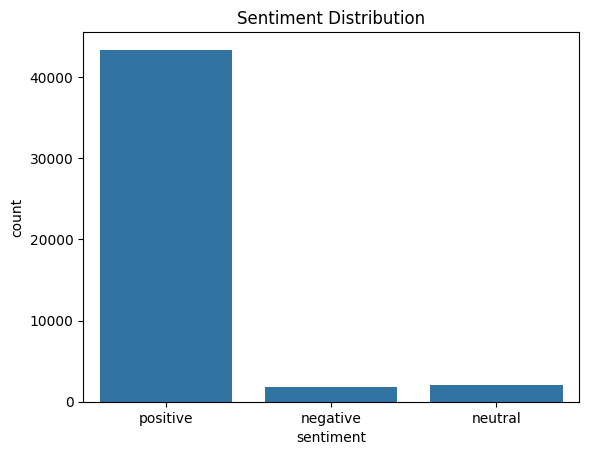

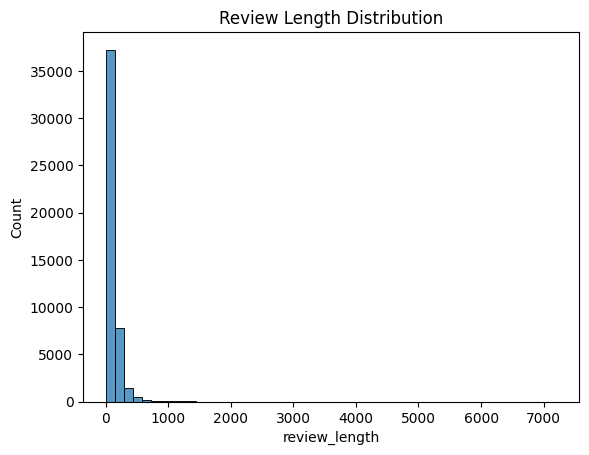

In [ ]:
# ===========================================-
# Install MLflow
# ===========================================
!pip install mlflow

# ===========================================
# Step 1: Mount Google Drive
# ===========================================
from google.colab import drive
drive.mount('/content/drive')

# ===========================================
# Step 2: Import Libraries
# ===========================================
import pandas as pd
import glob
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import mlflow
import mlflow.transformers

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ===========================================
# Step 3: Load and Merge CSV Files
# ===========================================
folder_path = '/content/drive/MyDrive/amazon_reviews/'
csv_files = glob.glob(os.path.join(folder_path, '*.csv'))

df_list = [pd.read_csv(file) for file in csv_files]
all_df = pd.concat(df_list, ignore_index=True)

# Keep only required columns
merged_df = all_df[['reviews.rating', 'reviews.text', 'reviews.title']].copy()
merged_df = merged_df.dropna(subset=['reviews.rating', 'reviews.text'])
merged_df = merged_df.drop_duplicates().reset_index(drop=True)

# ===========================================
# Step 4: Preprocess Text
# ===========================================
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

merged_df['reviews_cleaned'] = merged_df['reviews.text'].apply(preprocess_text)

# ===========================================
# Step 5: Map Sentiment
# ===========================================
def map_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

merged_df['sentiment'] = merged_df['reviews.rating'].apply(map_sentiment)
merged_df['full_review'] = merged_df['reviews.title'].fillna('') + ' ' + merged_df['reviews_cleaned']
merged_df = merged_df[['full_review', 'sentiment']]

# ===========================================
# Step 6: Data Visualization
# ===========================================
sns.countplot(x='sentiment', data=merged_df)
plt.title("Sentiment Distribution")
plt.show()

merged_df['review_length'] = merged_df['full_review'].apply(len)
sns.histplot(merged_df['review_length'], bins=50)
plt.title("Review Length Distribution")
plt.show()
merged_df.drop(columns=['review_length'], inplace=True)



In [2]:
# ===========================================
# Step 7a: Oversampling
# ===========================================
# def oversample_data(df):
#     df_positive = df[df['sentiment'] == 'positive']
#     df_neutral = df[df['sentiment'] == 'neutral']
#     df_negative = df[df['sentiment'] == 'negative']

#     max_size = max(len(df_positive), len(df_neutral), len(df_negative))
#     df_positive_over = resample(df_positive, replace=True, n_samples=max_size, random_state=42)
#     df_neutral_over = resample(df_neutral, replace=True, n_samples=max_size, random_state=42)
#     df_negative_over = resample(df_negative, replace=True, n_samples=max_size, random_state=42)

#     balanced_df = pd.concat([df_positive_over, df_neutral_over, df_negative_over])
#     return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# ===========================================
# Step 7b: Undersampling
# ===========================================
def undersample_data(df):
    df_positive = df[df['sentiment'] == 'positive']
    df_neutral = df[df['sentiment'] == 'neutral']
    df_negative = df[df['sentiment'] == 'negative']

    min_size = min(len(df_positive), len(df_neutral), len(df_negative))
    df_positive_under = resample(df_positive, replace=False, n_samples=min_size, random_state=42)
    df_neutral_under = resample(df_neutral, replace=False, n_samples=min_size, random_state=42)
    df_negative_under = resample(df_negative, replace=False, n_samples=min_size, random_state=42)

    balanced_df = pd.concat([df_positive_under, df_neutral_under, df_negative_under])
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Choose method here
merged_df_balanced = undersample_data(merged_df)  # <-- Change to oversample_data(merged_df) if needed
print("Class distribution after balancing:")
print(merged_df_balanced['sentiment'].value_counts())

Class distribution after balancing:
sentiment
neutral     1843
positive    1843
negative    1843
Name: count, dtype: int64


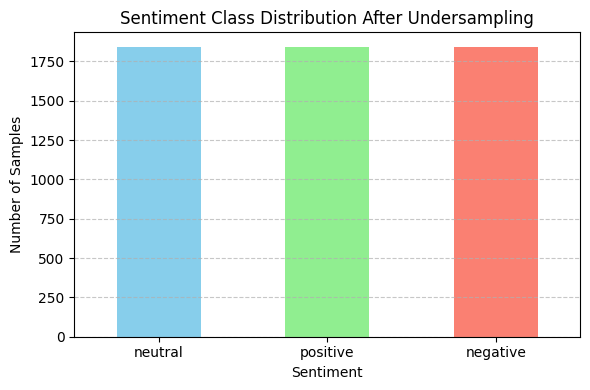

In [5]:
# Visualization after balancing dataset through undersampling

plt.figure(figsize=(6,4))
merged_df_balanced['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])

plt.title("Sentiment Class Distribution After Undersampling")
plt.xlabel("Sentiment")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# ===========================================
# Step 8: Train-Test Split
# ===========================================
train_full_review, test_full_review, train_sentiment, test_sentiment = train_test_split(
    merged_df_balanced['full_review'].tolist(),
    merged_df_balanced['sentiment'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=merged_df_balanced['sentiment']
)   

train_df = Dataset.from_dict({'review': train_full_review, 'sentiment': train_sentiment})
test_df = Dataset.from_dict({'review': test_full_review, 'sentiment': test_sentiment})
dataset = DatasetDict({'train': train_df, 'test': test_df})

# Convert sentiment to integers
sentiment_to_int = {'negative': 0, 'neutral': 1, 'positive': 2}
dataset = dataset.map(lambda x: {'labels': sentiment_to_int[x['sentiment']]})

# ===========================================
# Step 9: Tokenize
# ===========================================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch['review'], padding='max_length', truncation=True, max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/4423 [00:00<?, ? examples/s]

Map:   0%|          | 0/1106 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/4423 [00:00<?, ? examples/s]

Map:   0%|          | 0/1106 [00:00<?, ? examples/s]

In [6]:
# ===========================================
# Step 0: Mount Google Drive (for persistence)
# ===========================================
from google.colab import drive
drive.mount('/content/drive')

# Set a path to store models permanently in Drive
drive_model_path = "/content/drive/MyDrive/models/distilbert_model"

# ===========================================
# Step 10: Load Model
# ===========================================
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.transformers

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# ===========================================
# Step 11: Training with MLflow
# ===========================================
mlflow.set_tracking_uri("file:///content/drive/MyDrive/mlruns")  # Store MLflow logs/artifacts in Drive
mlflow.set_experiment("amazon_reviews_sentiment")

with mlflow.start_run(run_name="distilbert_balanced"):
    # Log parameters
    mlflow.log_param("model_name", "distilbert-base-uncased")
    mlflow.log_param("num_train_epochs", 3)
    mlflow.log_param("train_batch_size", 16)
    mlflow.log_param("eval_batch_size", 32)

    # Training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        report_to='none'
    )

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        return {
            'accuracy': accuracy_score(labels, preds),
            'precision': precision_score(labels, preds, average='weighted'),
            'recall': recall_score(labels, preds, average='weighted'),
            'f1': f1_score(labels, preds, average='weighted')
        }

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Train
    trainer.train()

    # Evaluate
    preds_output = trainer.predict(dataset['test'])
    metrics = compute_metrics(preds_output)
    print("Evaluation metrics:", metrics)

    for key, value in metrics.items():
        mlflow.log_metric(key, value)

    # ===========================================
    # Save model locally and in Google Drive
    # ===========================================
    local_model_path = "./distilbert_model"
    trainer.save_model(local_model_path)

    # Copy model to Google Drive for safe storage
    !cp -r ./distilbert_model "$drive_model_path"

    # ===========================================
    # Log model to MLflow (with artifact path)
    # ===========================================
    mlflow.transformers.log_model(
        transformers_model=local_model_path,
        artifact_path="distilbert_model",
        task="text-classification"
    )

print(f"Model saved to {drive_model_path} and logged in MLflow.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1123045656.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.834300,0.618114,0.738698,0.742184,0.738698,0.736627
2,0.582400,0.583718,0.747740,0.747577,0.747740,0.732487
3,0.376700,0.611087,0.771248,0.774198,0.771248,0.772400


Evaluation metrics: {'accuracy': 0.77124773960217, 'precision': 0.7741977361186287, 'recall': 0.77124773960217, 'f1': 0.7723995291914807}


2025/08/29 21:11:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/29 21:11:35 WARNING mlflow.transformers: The model card could not be retrieved from the hub due to Repo id must use alphanumeric chars or '-', '_', '.', '--' and '..' are forbidden, '-' and '.' cannot start or end the name, max length is 96: './distilbert_model'.
2025/08/29 21:11:35 WARNING mlflow.transformers: Unable to find license information for this model. Please verify permissible usage for the model you are storing prior to use.
2025/08/29 21:11:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/08/29 21:11:35 WARNING mlflow.utils.requirements_utils: Found to

Model saved to /content/drive/MyDrive/models/distilbert_model and logged in MLflow.



Classification Report:

              precision    recall  f1-score   support

    negative       0.85      0.80      0.83       368
     neutral       0.67      0.70      0.69       369
    positive       0.81      0.81      0.81       369

    accuracy                           0.77      1106
   macro avg       0.77      0.77      0.77      1106
weighted avg       0.77      0.77      0.77      1106



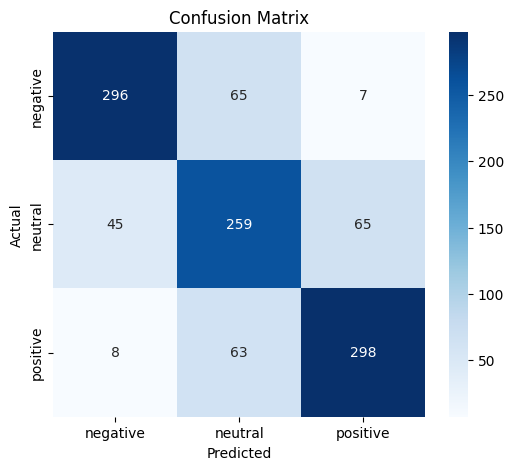

In [7]:
# ===========================================
# Step 12: Evaluation and Confusion Matrix
# ===========================================
labels = preds_output.label_ids
preds = preds_output.predictions.argmax(-1)

print("\nClassification Report:\n")
print(classification_report(labels, preds, target_names=['negative', 'neutral', 'positive']))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [9]:
# ===========================================
# Step 13: Display random reviews from each class
# ===========================================

def display_random_reviews(df, sentiment, n=5):
    """Displays n random reviews for a given sentiment."""
    print(f"\n--- Random {sentiment.capitalize()} Reviews ---")
    reviews = df[df['sentiment'] == sentiment]['full_review'].sample(n, random_state=42).tolist()
    for i, review in enumerate(reviews):
        print(f"{i+1}. {review}\n")

# Display 5 random reviews from each sentiment class
display_random_reviews(merged_df_balanced, 'negative')
display_random_reviews(merged_df_balanced, 'neutral')
display_random_reviews(merged_df_balanced, 'positive')


--- Random Negative Reviews ---
1. Disappointing. I expected more from AmazonBasics. reason havent held charge way duracells ive used past ive used smallwiredled lights use decorations lights take aa batteries old duracells ive used lasted several months hour houroff timer lasting weeks

2. Best to pay the price for the good ones put pumpkin candle halloween lasted days put flameless candle set lasted one week set timer go hours night really economical best pay price good ones

3. ipad is better old ipad quit decided go amazon fire tabletreally used play games entertainmenti hate itbattery life short pretty much need keep plugged times freezes shuts screens cant take anymore going buy another ipaddont waste money unimpressed product amazon general

4. Waste of money...Short lifespan awful far ive used toothbrush replace times months ive also used smoke detector replace within month period well seriously usually go years without replacing batteries smoke detector waste money

5. Leaky,

In [16]:
# ==============================
# Step 14: Testing the model
# ==============================

import torch

def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    # Move input tensors to the same device as the model
    inputs = {name: tensor.to(model.device) for name, tensor in inputs.items()}
    outputs = model(**inputs)
    pred = outputs.logits.argmax(-1).item()
    return ['negative','neutral','positive'][pred]

# Example:
print(predict_sentiment("Waste of money...Short lifespan awful far ive used toothbrush replace times months")) #negative
print(predict_sentiment("good like first going slow sometimes overall good product")) #neutral
print(predict_sentiment("love love alexa smart house items works great alexa makes life lil stress free")) #positive


negative
neutral
positive


In [18]:
!ls -l "./distilbert_model"

total 262504
-rw-r--r-- 1 root root       723 Aug 29 21:11 config.json
-rw-r--r-- 1 root root 267835644 Aug 29 21:11 model.safetensors
-rw-r--r-- 1 root root       125 Aug 29 21:11 special_tokens_map.json
-rw-r--r-- 1 root root      1227 Aug 29 21:11 tokenizer_config.json
-rw-r--r-- 1 root root    711661 Aug 29 21:11 tokenizer.json
-rw-r--r-- 1 root root      5713 Aug 29 21:11 training_args.bin
-rw-r--r-- 1 root root    231508 Aug 29 21:11 vocab.txt


In [19]:
!mkdir -p "/content/drive/MyDrive/models" #creates a directory

In [25]:
!cp -r ./distilbert_model "/content/drive/MyDrive/models/" #creates a copy of the model in the directory

In [24]:
# ==============================
# Step 15: Save the DataFrame
# ==============================

import pandas as pd
from google.colab import drive

# Define the path where you want to save the DataFrame
df_save_path = '/content/drive/MyDrive/merged_df.csv'

# Save the DataFrame to the specified path
# The `index=False` argument prevents pandas from saving the DataFrame's index as a column
merged_df.to_csv(df_save_path, index=False)